**DEMO OF standard gridder**

[Colab Link](https://colab.research.google.com/github/casangi/astroviper/blob/main/docs/core_tutorials/imaging/demo_standard_grid.ipynb)

# Demo of gridder


Description of notebook

The initial demo is to simulate a visibility set with 4 sources.
We demonstrate gridding those visibilities. 
Then we show the corrections needed to get the dirty image
Then we grid those model visibility data with the same convolution using the standard gridder and Fourier transform that back to an image and compare the source position and values
The second part compares with casa imaging using a standard gridder for a test data set

## Assumptions

The centre pixel is assumed to be the phasecentre.


    

## API

## Install AstroVIPER

Skip this cell if you don't want to install the latest version of AstroVIPER.

In [1]:
from importlib.metadata import version
import os

try:
    os.system("pip install --upgrade astroviper")

    import astroviper

    print("Using astroviper version", version("astroviper"))

except ImportError as exc:
    print(f"Could not import astroviper: {exc}")

Using astroviper version 0.0.30


In [2]:
import numpy as np
from matplotlib import pylab as pl
from astroviper.core.imaging.imaging_utils.standard_grid import *
from astroviper.core.imaging.imaging_utils.gcf_prolate_spheroidal import *
from astroviper.core.imaging.fft import fft_lm_to_uv
from astroviper.core.imaging.ifft import ifft_uv_to_lm


In [3]:
help(standard_grid_numpy_wrap_input_checked)


Help on function standard_grid_numpy_wrap_input_checked in module astroviper.core.imaging.imaging_utils.standard_grid:

standard_grid_numpy_wrap_input_checked(
    vis_data: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[complex]],
    uvw: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[float]],
    weight: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[float]],
    freq_chan: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[float]],
    cgk_1D: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[float]],
    image_size: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[int]],
    cell_size: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[float]],
    oversampling: int = 100,
    support: int = 7,
    complex_grid: bool = True,
    do_psf: bool = False,
    chan_mode: str = 'continuum'
) -> Tuple[numpy.ndarray, numpy.ndarray]
    Parameters
    ----------
    vis_data : np.NDArray[complex]
        Visibilities array has to be of matching shape with uvw
    uvw : np.NDArray[fl

In [4]:
help(grid2image_spheroid_ms4)

Help on function grid2image_spheroid_ms4 in module astroviper.core.imaging.imaging_utils.standard_grid:

grid2image_spheroid_ms4(
    vis: Union[xarray.core.datatree.DataTree, List[xarray.core.datatree.DataTree]],
    resid_array: numpy.ndarray,
    pixelincr: numpy.ndarray,
    support: int = 7,
    sampling: int = 100,
    dopsf: bool = False,
    column: str = 'VISIBILITY',
    chan_mode: str = 'continuum'
)
    Parameters
    ----------
    vis : single xarray.core.datatree.DataTree or a list of them
        an ms v4 compatible xarray
    resid_array : np.ndarray
        an array that defines the image shape
        will contain the image made
    pixelincr : np.ndarray
        pixel increment in the direction coordinate axes
    support : int, optional
        Size of support of the spheroidal convolution function
        The default is 7.
    sampling : int, optional
        oversampling of convolution function
        The default is 100.
    dopsf : bool, optional
        Grid w

In [5]:
from astroviper.core.imaging.imaging_utils.standard_gridding_example import generate_ms4_with_point_sources

Lets generate a ms4 dataArray with a few point sources in it

_sources_ will have the position and flux of source, _npix_ is the size of the image you may wish to make, _cell_ the cellsize determined from max uv and _ms4_ will be an xradio msv4 dataArray
Here we are putting 4 point sources of 1 Jy visibilities

In [6]:
nsources = 4
sources, npix, cell, ms4 = generate_ms4_with_point_sources(nsources, np.ones(nsources))

Initialize some gridding parameters. Most are taken from the meta data info of the _ms4_
we'll use a prolate spheroidal function oversampled by 100 and having a support of 7 pixels

In [7]:
support=7
oversampling=100
#conv func
cgk_1D = create_prolate_spheroidal_kernel_1D(oversampling, support)
vis_data=ms4.VISIBILITY.data
uvw=ms4.UVW.data
#We will initialize all the weights to 1
dims = ms4.dims
weight = np.ones([dims["time"], dims["baseline_id"], dims["frequency"], 1])
freq_chan = ms4.coords["frequency"].values
image_size=np.array([npix, npix])
cell_size= np.array([cell.to("rad").value, cell.to("rad").value])
complex_grid=True
do_psf=False
chan_mode="continuum"

Now we call the gridding code; it returns the complex grid and sumweights

In [8]:
grid, sumwt = standard_grid_numpy_wrap_input_checked(
            vis_data=vis_data,
            uvw=uvw,
            weight=weight,
            freq_chan=freq_chan,
            cgk_1D=cgk_1D,
            image_size=image_size,
            cell_size=cell_size,
            oversampling=oversampling,
            support=support,
            complex_grid=complex_grid,
            do_psf=do_psf,
            chan_mode=chan_mode
        )

Now FFT back to image domain and correct for the convolution function

In [9]:
kernel, corrTerm = create_prolate_spheroidal_kernel(
            oversampling, support, image_size)
dirty_im = (
            ifft_uv_to_lm(grid, axes=[2, 3])
            / corrTerm
            * image_size[0]
            * image_size[1]
            / sumwt
        )

locate the sources and compare to what was simulated in 

In [10]:
pos_peaks=np.where(dirty_im[0,0,:,:] > 0.9)

In [11]:
for posy, posx in zip(pos_peaks[0], pos_peaks[1]):
    print(f'source found at [{posy, posx}] has value of {dirty_im[0,0, posy, posx]}')

source found at [(np.int64(77), np.int64(91))] has value of 1.0179322723643305
source found at [(np.int64(77), np.int64(108))] has value of 1.0124322679670061
source found at [(np.int64(100), np.int64(99))] has value of 0.96902298875079
source found at [(np.int64(115), np.int64(102))] has value of 0.9298239565070073


In [12]:
for k in range(len(sources[0])):
    print(f'Simulated source at [{sources[0][k], sources[1][k]}] has value of {sources[2][k]}')

Simulated source at [(np.int64(77), np.int64(108))] has value of 1.0
Simulated source at [(np.int64(115), np.int64(102))] has value of 1.0
Simulated source at [(np.int64(77), np.int64(91))] has value of 1.0
Simulated source at [(np.int64(100), np.int64(99))] has value of 1.0


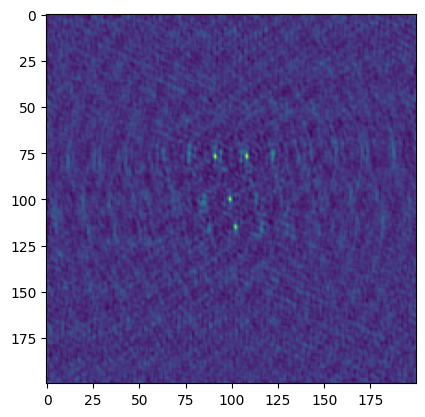

In [13]:
pl.imshow(dirty_im[0,0,:,:])

**CASA comparison**
We will download an ms v4 of data that we have gridded and image in casa

In [19]:
!pip install gdown
import gdown
# get the ms v4
gdown.download(id='19br3EYwdtu82iF4JkRaX-9u2_bhNAMjJ', output='lala.zip', fuzzy=True)
!unzip -o lala.zip
# get the continuum and cube images done in casa
gdown.download(id='1hHLUB9uJT9okRpYHHHBu4WUXcsOW6Sk2', output='cube_image.npy', fuzzy=True)
gdown.download(id='1tFHACLA-5qnpz76HG2UbixakqSX20MIH', output='cont_image.npy', fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=19br3EYwdtu82iF4JkRaX-9u2_bhNAMjJ
To: /Users/jsteeb/Dropbox/astroviper/docs/core_tutorials/imaging/lala.zip
100%|██████████| 12.5M/12.5M [00:00<00:00, 27.6MB/s]


Archive:  lala.zip
  inflating: ngc5921_casa_model.ps.zarr/.zmetadata  
 extracting: ngc5921_casa_model.ps.zarr/.zattrs  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/frequency/0  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/frequency/.zarray  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/frequency/.zattrs  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/ANTENNA_RECEPTOR_ANGLE/0.0  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/ANTENNA_RECEPTOR_ANGLE/.zarray  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/ANTENNA_RECEPTOR_ANGLE/.zattrs  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/cartesian_pos_label/0  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/cartesian_pos_label/.zarray  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/cartesian_pos_label/.zattrs  
  inflating: ngc5921_casa_model.ps.zarr/ngc5921_model_0/antenna_xds/r

Downloading...
From: https://drive.google.com/uc?id=1hHLUB9uJT9okRpYHHHBu4WUXcsOW6Sk2
To: /Users/jsteeb/Dropbox/astroviper/docs/core_tutorials/imaging/cube_image.npy
100%|██████████| 33.0M/33.0M [00:01<00:00, 25.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tFHACLA-5qnpz76HG2UbixakqSX20MIH
To: /Users/jsteeb/Dropbox/astroviper/docs/core_tutorials/imaging/cont_image.npy
100%|██████████| 524k/524k [00:00<00:00, 6.02MB/s]


'cont_image.npy'

Now let us make a continuum image from the ms4 downloaded

In [15]:
from astroviper.core.imaging.imaging_utils.standard_grid import grid2image_spheroid_ms4
from xradio.measurement_set import load_processing_set
from astropy import units as u
#image incr
incr=(15*u.arcsec).to('rad').value
#get ms4 to use
ngc_xdt=load_processing_set('ngc5921_casa_model.ps.zarr')
ngc_mod=ngc_xdt['ngc5921_model_0']
#continuum image
## data has RR and LL so 2 pol. corr2Stokes will have to be applied
cont_dirty=np.zeros([1,2,256, 256], dtype=float)
grid2image_spheroid_ms4(vis=ngc_mod, resid_array=cont_dirty, pixelincr=np.array([-incr, incr]), support=7, sampling=100, dopsf=False, column='VISIBILITY', chan_mode='continuum')

Doing a poor man's corr2Stokes

In [16]:
cont_dirty=np.sum(cont_dirty, axis=1)/2.0

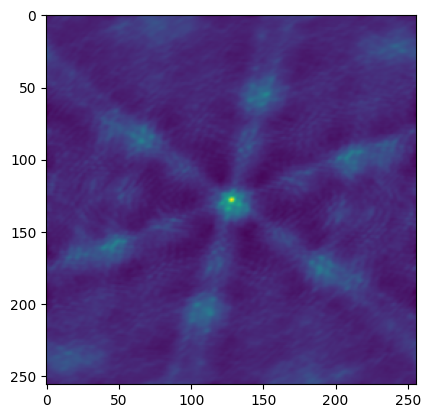

In [17]:
pl.imshow(cont_dirty[0,:,:])

In [20]:
casa_cont=np.load('cont_image.npy')

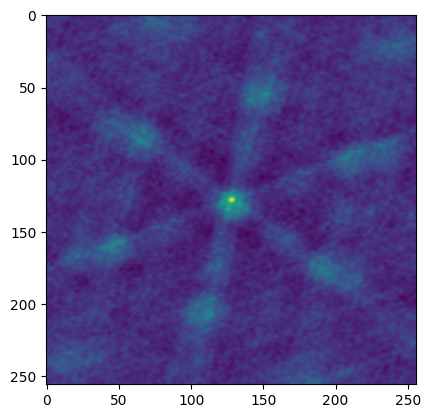

In [21]:
pl.imshow(casa_cont)

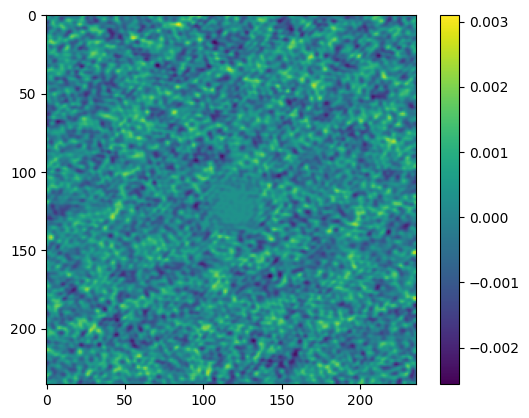

In [22]:
pl.imshow(casa_cont[10:246,10:246]-cont_dirty[0,10:246,10:246])
pl.colorbar()

In [23]:
cube_dirty=np.zeros([63,2,256,256], dtype=float)
grid2image_spheroid_ms4(vis=ngc_mod, resid_array=cube_dirty, pixelincr=np.array([-incr, incr]), support=7, sampling=100, dopsf=False, column='VISIBILITY', chan_mode='cube')

Correlations to Stokes

In [24]:
cube_dirty=np.sum(cube_dirty, axis=1)/2

A little function to view cubes in a notebook

In [25]:
from ipywidgets import interactive, IntSlider
from IPython.display import display


def cube_view(cube):
    # Create the interactive plot
    nchan=cube.shape[0]
    # Create an interactive slider
    def create_cubeSlider(nchan):
        return IntSlider(
            min=0,
            max=nchan - 1,
            step=1,
            description='Channel Index:',
            continuous_update=False,  # Update only when the slider is released
            )
    # Define a function to update the plot based on the slider value
    def update_plot(channel_index):
        pl.imshow(cube[channel_index, :, :], cmap='viridis')
        pl.colorbar()
        pl.title(f'channel {channel_index}')
        pl.axis('off')
        pl.show()
    interactive_plot = interactive(update_plot, channel_index=create_cubeSlider(nchan))

    # Display the slider and the plot
    display(interactive_plot)

Let's look at the image produced

In [26]:
cube_view(cube_dirty)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Channel Index:', max=62), Outpu…

Similar image made in casa

In [27]:
casa_cube=np.moveaxis(np.load('cube_image.npy'), -1, 0)

In [28]:
cube_view(casa_cube)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Channel Index:', max=62), Outpu…

Let's look at the difference casa edges are kind of masked so avoiding those in the difference

In [29]:
cube_view(casa_cube[:,25:231, 25:231] - cube_dirty[:, 25:231, 25:231])

interactive(children=(IntSlider(value=0, continuous_update=False, description='Channel Index:', max=62), Outpu…